In [9]:
## Examnine some Non-LTE quantities

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

import rhanalyze

In [2]:
rhd1 = rhanalyze.rhout('/home/han/Source/rh_v2/rhf1d/run_FALC')

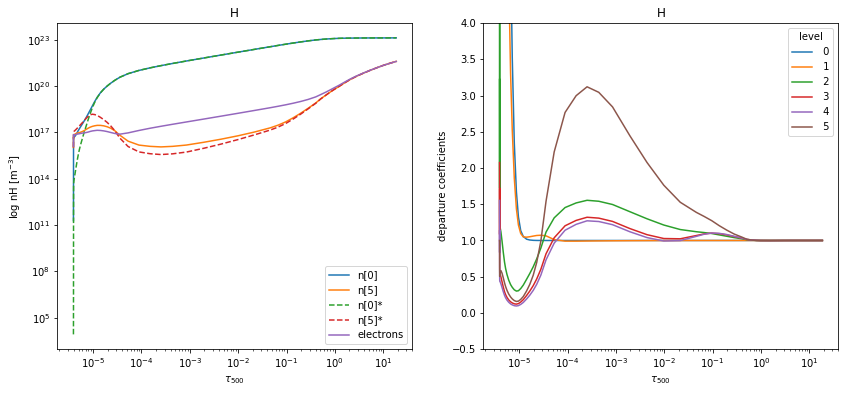

In [3]:
KM_TO_M = 1.0E3

ATOMNO = 1
plt.figure(figsize=[14, 6])

# Plot population numbers, both LTE (*), and Non-LTE

plt.subplot(121)
plt.plot(rhd1.geometry.tau500, rhd1.atoms[ATOMNO].n[:,0], label='n[0]')
plt.plot(rhd1.geometry.tau500, rhd1.atoms[ATOMNO].n[:,5], label='n[5]')

#LTE quantities
plt.plot(rhd1.geometry.tau500, rhd1.atoms[ATOMNO].nstar[:, 0], '--', label='n[0]*')
plt.plot(rhd1.geometry.tau500, rhd1.atoms[ATOMNO].nstar[:, 5], '--', label='n[5]*')
plt.plot(rhd1.geometry.tau500, rhd1.atmos.n_elec, label='electrons')
plt.xlabel(r'$\tau_{500}$')
plt.ylabel('log nH [m$^{-3}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(rhd1.atoms[ATOMNO].atomID)
plt.legend()

# Non-LTE departure coefficients: ratio of n*/n

plt.subplot(122)
for i in range(rhd1.atoms[ATOMNO].Nlevel):
    plt.plot(rhd1.geometry.tau500, rhd1.atoms[ATOMNO].n[:, i]/rhd1.atoms[ATOMNO].nstar[:, i],\
             label='{:2d}'.format(i))

plt.xlabel(r'$\tau_{500}$')
plt.ylabel('departure coefficients')
plt.ylim([-0.5, 4.0])
plt.xscale('log')
plt.legend(title='level')
plt.title(rhd1.atoms[ATOMNO].atomID)

plt.show()

(82, 6, 6)


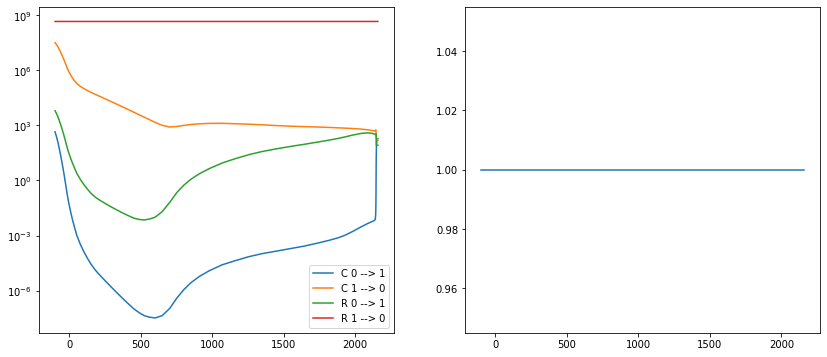

In [4]:
## Plot some radiative and collisional rates

print(rhd1.atoms[ATOMNO].Cij.shape)
plt.figure(figsize=[14, 6])

plt.subplot(121)
plt.plot(rhd1.geometry.height/KM_TO_M, rhd1.atoms[ATOMNO].Cij[:, 0,1], label='C 0 --> 1')
plt.plot(rhd1.geometry.height/KM_TO_M, rhd1.atoms[ATOMNO].Cij[:, 1,0], label='C 1 --> 0')
plt.plot(rhd1.geometry.height/KM_TO_M, rhd1.atoms[ATOMNO].transition[0].Rij, label='R 0 --> 1')
plt.plot(rhd1.geometry.height/KM_TO_M, rhd1.atoms[ATOMNO].transition[0].Rji, label='R 1 --> 0')
plt.yscale("log")
plt.legend()

## Detailed balance should hold: i.e., n_0 C_01 = n_1 C_10

detbalup = rhd1.atoms[ATOMNO].nstar[:,0] * rhd1.atoms[ATOMNO].Cij[:,0,1]
detbaldw = rhd1.atoms[ATOMNO].nstar[:,1] * rhd1.atoms[ATOMNO].Cij[:,1,0]

plt.subplot(122)
plt.plot(rhd1.geometry.height/KM_TO_M, detbalup/detbaldw)

plt.show()

# Collisional destruction parameter $\epsilon$

>$ \epsilon = \frac{C_{ji}}{A_{ji} + B_{ji}\overline{J} + C_{ji}} = \frac{C_{ji}}{R_{ji} + C_{ji}} $

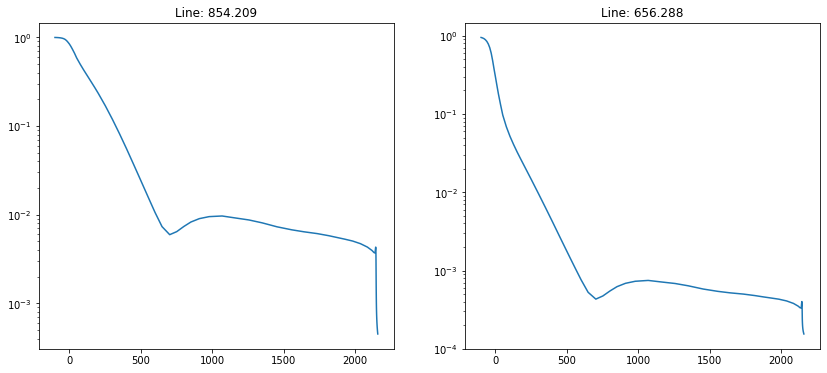

In [5]:
ATOMNO = 0
LINENO = 4

i = rhd1.atoms[ATOMNO].transition[LINENO].i
j = rhd1.atoms[ATOMNO].transition[LINENO].j
eps = rhd1.atoms[ATOMNO].Cij[:,j,i] / (rhd1.atoms[ATOMNO].transition[LINENO].Rji + \
                                       rhd1.atoms[ATOMNO].Cij[:,j,i])

plt.figure(figsize=[14, 6])

plt.subplot(121)
plt.plot(rhd1.geometry.height/KM_TO_M, eps)
plt.yscale("log")
plt.title("Line: {:2.3f}".format(rhd1.atoms[ATOMNO].transition[LINENO].lambda0))

ATOMNO = 1
i = rhd1.atoms[ATOMNO].transition[LINENO].i
j = rhd1.atoms[ATOMNO].transition[LINENO].j
eps = rhd1.atoms[ATOMNO].Cij[:,j,i] / (rhd1.atoms[ATOMNO].transition[LINENO].Rji + \
                                       rhd1.atoms[ATOMNO].Cij[:,j,i])

plt.subplot(122)
plt.plot(rhd1.geometry.height/KM_TO_M, eps)
plt.yscale("log")
plt.title("Line: {:2.3f}".format(rhd1.atoms[ATOMNO].transition[LINENO].lambda0))

plt.show()

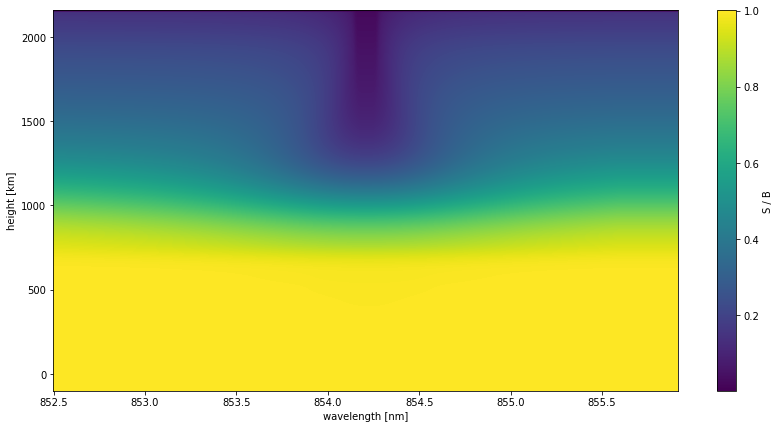

In [16]:
## Source function over Planck function

ATOMNO = 0
LINENO = 4

kms = rhd1.geometry.height / KM_TO_M

lblue = rhd1.atoms[ATOMNO].transition[LINENO].Nblue
Nwave = rhd1.atoms[ATOMNO].transition[LINENO].Nwave
lred  = lblue + Nwave - 1

SoverB = np.zeros([rhd1.geometry.Ndep, Nwave-1], dtype='float')

for la in range(lblue, lred, 1):
    rhd1.opacity.read(la, rhd1.geometry.Nrays-1)
    rhd1.opacity.Source()
    rhd1.opacity.Planck()
    
    SoverB[:, la-lblue] = rhd1.opacity.S / rhd1.opacity.Bp

f_SB = interpolate.interp2d(rhd1.spectrum.waves[lblue:lred], kms, SoverB, kind='cubic')

wave_lin  = np.arange(rhd1.spectrum.waves[lblue], rhd1.spectrum.waves[lred], 0.01)
kms_lin   = np.arange(kms[-1], kms[0], 10.0)
SB_lin    = f_SB(wave_lin, kms_lin)

## Display map
fig, axs = plt.subplots(figsize=(14, 7), sharey=True)
im = axs.imshow(SB_lin, interpolation='bilinear', origin='lower',\
                extent=[rhd1.spectrum.waves[lblue], rhd1.spectrum.waves[lred], kms[-1], kms[0]],\
                aspect="auto")
axs.set(xlabel='wavelength [nm]', ylabel='height [km]')

plt.colorbar(im, label='S / B')
plt.show()